In [23]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
from scipy import stats

In [24]:
file_content = open('2024-03-03-19-14.txt', 'r').read()

In [25]:
benchmarking_pattern = re.compile(r"Benchmarking (\w+) (\w+)_([a-z]+):")
time_pattern = re.compile(r".* run \d+: (\d+)")

def process_content(content):
    data = collections.deque()
    current_runtime = ""
    current_module = ""
    current_language = ""
    times = []

    for line in content.splitlines():
        benchmarking_match = benchmarking_pattern.match(line)
        if benchmarking_match:
            if times:
                data.append(store_statistics(current_module, current_language, current_runtime, times))
                times = [] 
            current_runtime, current_module, current_language = benchmarking_match.groups()

        time_match = time_pattern.match(line)
        if time_match:
            times.append(int(time_match.group(1)))
    if times:
        data.append(store_statistics(current_module, current_language, current_runtime, times))

    return pd.DataFrame(list(data), columns=["module", "language", "runtime", "average", "min", "max", "95th_percentile", "std_deviation", "count", "trimmed_mean(90%)", "median", "mad", "q1", "q3"])

def store_statistics(module, language, runtime, times):
    times_array = np.array(times)
    times_array.sort()
    trimmed_mean = stats.trim_mean(times_array, 0.05)
    median = np.median(times_array)
    mad = np.median(np.abs(times_array - median)) 
    q1 = times_array[int(0.25 * len(times_array))]  
    q3 = times_array[int(0.75 * len(times_array))] 
    return (
        module,
        language,
        runtime,
        np.mean(times_array).astype(int),
        times_array[0].astype(int),  
        times_array[-1].astype(int),  
        times_array[int(0.95 * len(times_array))].astype(int),
        np.std(times_array).astype(int),
        len(times),
        trimmed_mean.astype(int),
        median.astype(int),
        mad.astype(int),
        q1.astype(int),
        q3.astype(int)
    )

data = process_content(file_content)
data

,module,language,runtime,average,min,max,95th_percentile,std_deviation,count,trimmed_mean(90%),median,mad,q1,q3
0,add,c,bin,35165,33407,105240,33833,9139,100,33461,33444,18,33426,33463
1,add,c,wasmtime,56943,54795,67610,66833,3499,100,56488,55759,249,55574,56055
2,add,c,wasmer,72973,64258,198943,71406,18096,100,69687,69648,278,69407,69981
3,add,go,bin,11624,11314,35685,11463,2418,100,11380,11371,19,11352,11407
4,add,go,wasmtime,26360,25833,26981,26759,213,100,26359,26361,121,26222,26463
5,add,go,wasmer,31254,30408,69759,31203,3875,100,30869,30870,148,30722,31018
6,add,rust,bin,110362,105906,274257,106592,21991,100,106177,106165,91,106091,106258
7,add,rust,wasmtime,274365,272795,301702,274609,3287,100,273883,273877,305,273590,274220
8,add,rust,wasmer,261538,253535,402516,312293,24184,100,257113,254331,296,254035,254591
9,fib,c,bin,518416643,517803059,520640686,519886396,515852,100,518350048,518285916,197489,518142315,518511259


In [26]:
data['runtime'] = data['runtime'].replace('bin', 'binary')
data = data.drop(columns=['std_deviation', 'count'])
binary_means = data[data['runtime'] == 'binary'].set_index(['module', 'language'])['trimmed_mean(90%)'].to_dict()

def calculate_ratio(row):
    key = (row['module'], row['language'])
    if key in binary_means:
        return row['trimmed_mean(90%)'] / binary_means[key]
    else:
        return np.nan

data['mean_ratio'] = data.apply(calculate_ratio, axis=1)
data['mean_ratio'] = data['mean_ratio'].round(2)
data

,module,language,runtime,average,min,max,95th_percentile,trimmed_mean(90%),median,mad,q1,q3,mean_ratio
0,add,c,binary,35165,33407,105240,33833,33461,33444,18,33426,33463,1.00
1,add,c,wasmtime,56943,54795,67610,66833,56488,55759,249,55574,56055,1.69
2,add,c,wasmer,72973,64258,198943,71406,69687,69648,278,69407,69981,2.08
3,add,go,binary,11624,11314,35685,11463,11380,11371,19,11352,11407,1.00
4,add,go,wasmtime,26360,25833,26981,26759,26359,26361,121,26222,26463,2.32
5,add,go,wasmer,31254,30408,69759,31203,30869,30870,148,30722,31018,2.71
6,add,rust,binary,110362,105906,274257,106592,106177,106165,91,106091,106258,1.00
7,add,rust,wasmtime,274365,272795,301702,274609,273883,273877,305,273590,274220,2.58
8,add,rust,wasmer,261538,253535,402516,312293,257113,254331,296,254035,254591,2.42
9,fib,c,binary,518416643,517803059,520640686,519886396,518350048,518285916,197489,518142315,518511259,1.00


In [27]:
# measurements of these modules are effected by the add module
# we need to subtract the measurements of the add module from the other modules
labels = ["time", "std_output", "dynamic_memory"]
measures = ['trimmed_mean(90%)', 'q1', 'q3', '95th_percentile', 'median']
for measure in measures:
    adjusted_measure = 'adjusted_' + measure
    data[adjusted_measure] = data[measure] 
    for label in labels:
            for runtime in data['runtime'].unique():
                for language in data['language'].unique():
                    adjustment = data.loc[(data['module'] == 'add') & (data['runtime'] == runtime) & (data['language'] == language), measure].values[0]
                    data.loc[(data['module'] == label) & (data['runtime'] == runtime) & (data['language'] == language), adjusted_measure] -= adjustment

In [28]:
# adjusted mean ratio should be calculated after the subtraction
binary_means = data[data['runtime'] == 'binary'].set_index(['module', 'language'])['adjusted_trimmed_mean(90%)'].to_dict()
def calculate_ratio(row):
    key = (row['module'], row['language'])
    if key in binary_means:
        return row['adjusted_trimmed_mean(90%)'] / binary_means[key]
    else:
        return np.nan

data['adjusted_mean_ratio'] = data.apply(calculate_ratio, axis=1)
data['adjusted_mean_ratio'] = data['adjusted_mean_ratio'].round(2)
data

,module,language,runtime,average,min,max,95th_percentile,trimmed_mean(90%),median,mad,q1,q3,mean_ratio,adjusted_trimmed_mean(90%),adjusted_q1,adjusted_q3,adjusted_95th_percentile,adjusted_median,adjusted_mean_ratio
0,add,c,binary,35165,33407,105240,33833,33461,33444,18,33426,33463,1.00,33461,33426,33463,33833,33444,1.00
1,add,c,wasmtime,56943,54795,67610,66833,56488,55759,249,55574,56055,1.69,56488,55574,56055,66833,55759,1.69
2,add,c,wasmer,72973,64258,198943,71406,69687,69648,278,69407,69981,2.08,69687,69407,69981,71406,69648,2.08
3,add,go,binary,11624,11314,35685,11463,11380,11371,19,11352,11407,1.00,11380,11352,11407,11463,11371,1.00
4,add,go,wasmtime,26360,25833,26981,26759,26359,26361,121,26222,26463,2.32,26359,26222,26463,26759,26361,2.32
5,add,go,wasmer,31254,30408,69759,31203,30869,30870,148,30722,31018,2.71,30869,30722,31018,31203,30870,2.71
6,add,rust,binary,110362,105906,274257,106592,106177,106165,91,106091,106258,1.00,106177,106091,106258,106592,106165,1.00
7,add,rust,wasmtime,274365,272795,301702,274609,273883,273877,305,273590,274220,2.58,273883,273590,274220,274609,273877,2.58
8,add,rust,wasmer,261538,253535,402516,312293,257113,254331,296,254035,254591,2.42,257113,254035,254591,312293,254331,2.42
9,fib,c,binary,518416643,517803059,520640686,519886396,518350048,518285916,197489,518142315,518511259,1.00,518350048,518142315,518511259,519886396,518285916,1.00


In [29]:
def plot_module(module_name,scale='linear'):
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(x='language', y='adjusted_trimmed_mean(90%)', hue='runtime', data= data[data['module'] == module_name])

    languages = data['language'].unique()
    runtimes = data['runtime'].unique()
    max_height = max([p.get_height() for p in barplot.patches])
    min_height = min([p.get_height() for p in barplot.patches]) + 1
    offset_ratio = 0.02  # Set the offset as a ratio of the bar height
    plt.yscale(scale)
    for i, p in zip(range(9), barplot.patches):
        height = p.get_height()
        language = languages[i % len(languages)]
        runtime = runtimes[i // len(languages)]
        row = data[(data['language'] == language) & (data['runtime'] == runtime) & (data['module'] == module_name)]
        ratio = row['adjusted_mean_ratio'].values[0]
        percentile_95 = row['adjusted_95th_percentile'].values[0] 
        if ratio != 1:
            barplot.text(p.get_x() + p.get_width() / 2, height * (1 + offset_ratio), f'{ratio}x', ha='center')
        plt.scatter(p.get_x() + p.get_width() / 2, percentile_95, color='red')

    plt.scatter([], [], color='red', label='95th percentile')
    barplot.legend_.remove()

    plt.xlabel('Language')
    plt.ylabel('Time (ns)')
    plt.show()

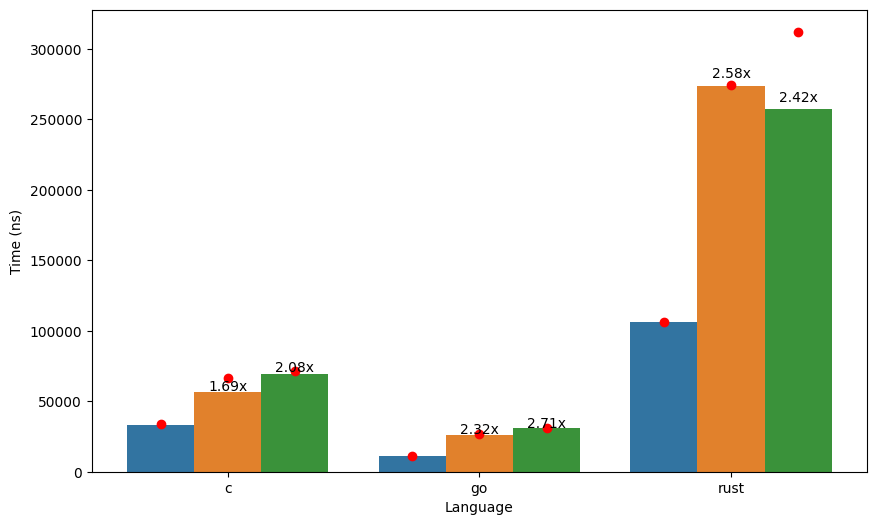

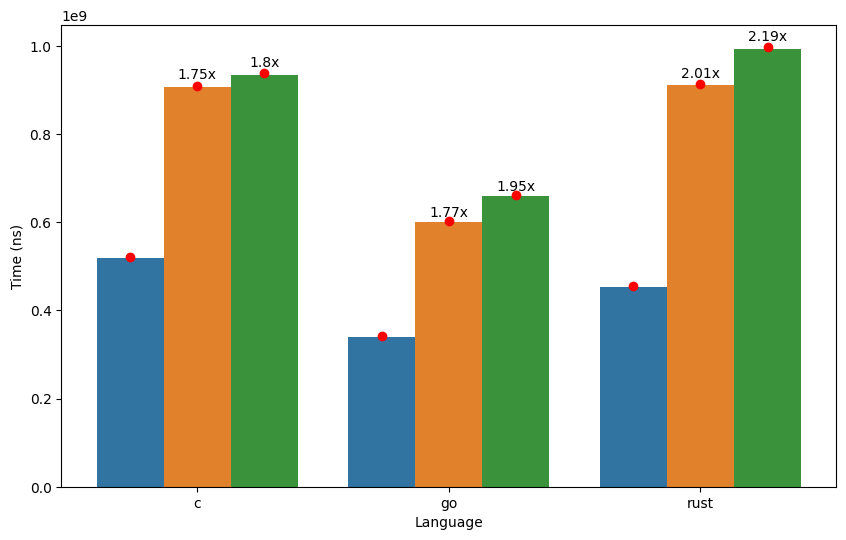

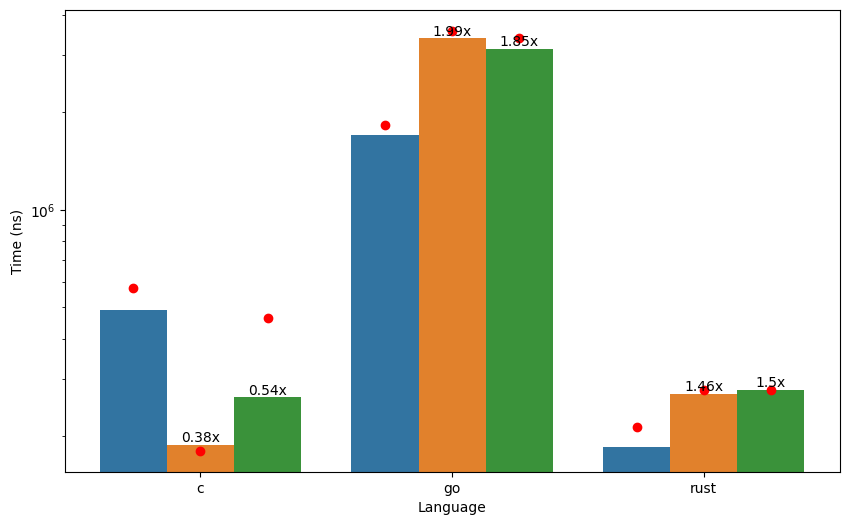

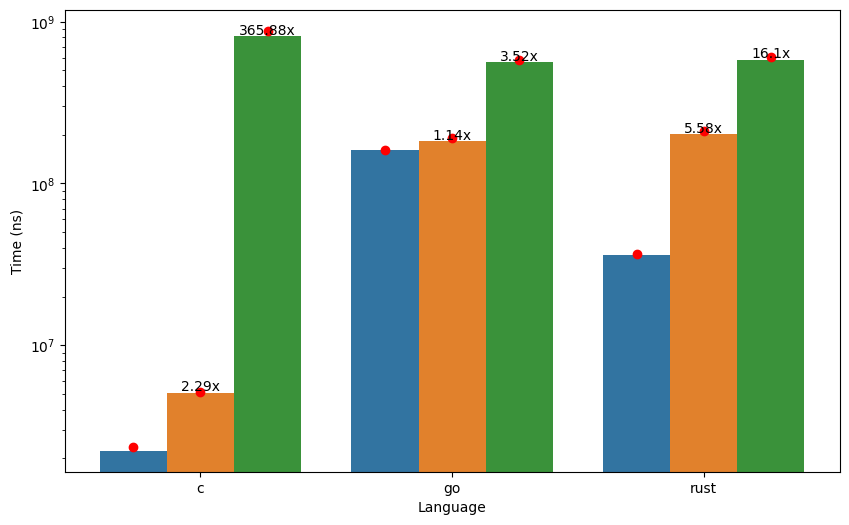

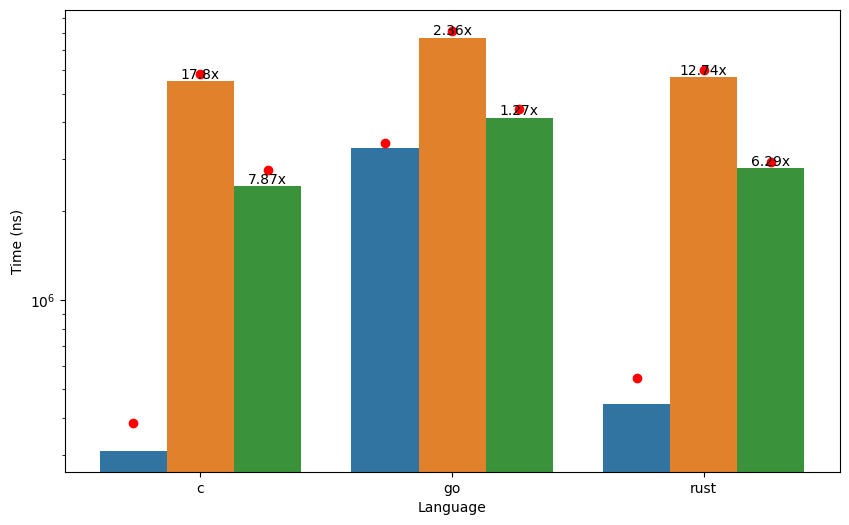

In [30]:
for module in data['module'].unique():
    if module in ['time', 'std_output', 'dynamic_memory']:
        plot_module(module, 'log')
    else:
        plot_module(module)

In [31]:
def calculate_ratio(module):
    ratios = []
    for language in data['language'].unique():
        for runtime in data['runtime'].unique():
            row = data[(data['module'] == module) & (data['language'] == language) & (data['runtime'] == runtime)]
            ratio = row['adjusted_95th_percentile'].values[0] / row['adjusted_trimmed_mean(90%)'].values[0]
            ratio = round(ratio * 100, 2)  
            ratios.append((language, runtime, ratio))

    df = pd.DataFrame(ratios, columns=['Language', 'Runtime', 'Ratio'])

    df_pivot = df.pivot(index='Language', columns='Runtime', values='Ratio')
    df_pivot.index.name = None

    df_pivot.to_csv('ratios_' + module + '.csv')

    return df_pivot

In [ ]:
for module in data['module'].unique():
        calculate_ratio(module)